In [24]:
import cv2
from pathlib import Path
from PIL import Image

In [25]:
path = Path().resolve()
# image_path = path.parent / "day_color(large sample)" / "5.JPG"
test_image_path = "../data/day_color/74.JPG"
print(test_image_path)

../data/day_color/74.JPG


In [26]:
car_image = cv2.imread(str(test_image_path),0)

In [27]:
def show_img(img):
    cv2.imshow('image',img)
    k = cv2.waitKey(0)
    if k == 27:         # wait for ESC key to exit
        cv2.destroyAllWindows()

In [29]:
gray_car_image = car_image * 255
threshold_value, binary_car_image = cv2.threshold(gray_car_image,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
print(threshold_value)

In [33]:
show_img(th3)

# 1st method (average)
## Scikit image approach
#### kudos to https://blog.devcenter.co/developing-a-license-plate-recognition-system-with-machine-learning-in-python-787833569ccd

In [34]:
from skimage.io import imread
from skimage.filters import threshold_otsu, threshold_adaptive, threshold_local
import matplotlib.pyplot as plt
from skimage import measure
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
from skimage.transform import resize
%matplotlib inline

(480, 640)


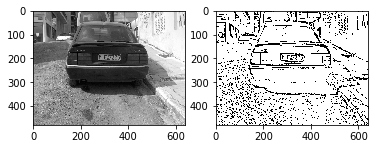

array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ..., 
       [ True,  True, False, ...,  True,  True,  True],
       [ True, False,  True, ..., False,  True,  True],
       [ True, False, False, ..., False, False,  True]], dtype=bool)

In [40]:
def binary_img_from_path(img_path: str):
    car_image = imread(img_path, as_grey=True)
    print(car_image.shape)
    gray_car_image = car_image * 255
    fig, (ax1, ax2) = plt.subplots(1, 2)
    ax1.imshow(gray_car_image, cmap="gray")
    threshold_value = threshold_local(gray_car_image, 31, offset=15)
    binary_car_image = gray_car_image > threshold_value
    ax2.imshow(binary_car_image, cmap="gray")
    plt.show()
    return binary_car_image
binary_img_from_path(test_image_path)

### CCA

0.7368421052631579
0.75
2.1333333333333333
0.3684210526315789
1.4242424242424243
0.28865979381443296


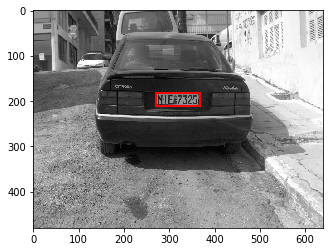

[array([[False,  True,  True, ..., False, False,  True],
        [False,  True,  True, ...,  True,  True, False],
        [ True,  True, False, ...,  True,  True,  True],
        ..., 
        [ True,  True, False, ...,  True,  True, False],
        [False,  True,  True, ...,  True,  True, False],
        [False, False, False, ...,  True, False, False]], dtype=bool)]

In [39]:
def get_roi_from_binarized(binary_img):
    label_image = measure.label(binary_img)

    plate_objects_cordinates = []
    plate_like_objects = []
    fig, (ax1) = plt.subplots(1)
    ax1.imshow(gray_car_image, cmap="gray");
    # 28h, 107w ratio 0.26168224299
    for region in measure.regionprops(label_image):
        if region.area < 150:
            continue
        # the bounding box coordinates
        min_row, min_col, max_row, max_col = region.bbox
        region_height = max_row - min_row
        region_width = max_col - min_col
        # ensuring that the region identified satisfies the condition of a typical license plate
        dim_ratio = region_height/region_width
        print(dim_ratio)
        if dim_ratio > 0.20 and dim_ratio < 0.30:
            plate_like_objects.append(binary_img[min_row:max_row,
                                      min_col:max_col])
            plate_objects_cordinates.append((min_row, min_col,
                                                  max_row, max_col))
            rectBorder = patches.Rectangle((min_col, min_row), max_col-min_col, max_row-min_row, edgecolor="red", linewidth=2, fill=False)
            ax1.add_patch(rectBorder)
    plt.show()
    assert len(plate_like_objects) > 0
    return plate_like_objects
get_roi_from_binarized(binary_car_image)

/home/alcaster/.pyenv/versions/3.6-dev/envs/ml/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


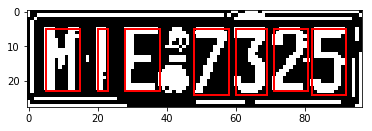

In [37]:
def licence_plate_chars_from_roi(roi):
    license_plate = np.invert(roi)
    labelled_plate = measure.label(license_plate)

    fig, ax1 = plt.subplots(1)
    ax1.imshow(license_plate, cmap="gray")

    character_dimensions = (0.63*license_plate.shape[0], 0.95*license_plate.shape[0], 0.02*license_plate.shape[1], 0.20*license_plate.shape[1])
    min_height, max_height, min_width, max_width = character_dimensions
    characters = []
    counter=0
    column_list = []
    for regions in measure.regionprops(labelled_plate):
        y0, x0, y1, x1 = regions.bbox
        region_height = y1 - y0
        region_width = x1 - x0

        if region_height > min_height and region_height < max_height and region_width > min_width and region_width < max_width:
            roi = license_plate[y0:y1, x0:x1]

            rect_border = patches.Rectangle((x0, y0), x1 - x0, y1 - y0, edgecolor="red",
                                           linewidth=2, fill=False)
            ax1.add_patch(rect_border)
            resized_char = resize(roi, (20, 20))
            characters.append(resized_char)

            column_list.append(x0)

    assert len(characters), "There is too many characters"
    plt.show()
licence_plate_chars_from_roi(plate_like_objects[0])

# 2nd method todo
##### Segmenting using https://gurus.pyimagesearch.com/lesson-sample-segmenting-characters-from-license-plates/